# Humpback Whale Image Classifier Kaggle Competition

In [1]:
# Reload modules before executing user code
%reload_ext autoreload
# Reload all modules (except those excluded by %aimport)
%autoreload 2
# Show plots within this notebook
%matplotlib inline

## Dataset Exploration

(This section of our analysis borrows heavily on the work of others, as we ourselves are learning. In particular, we heavily borrow from Lex Toumbourou's kernel "Humpback Whale ID: Data and Aug Exploration" found __[here](https://www.kaggle.com/lextoumbourou/humpback-whale-id-data-and-aug-exploration/notebook)__.)

The first step with any kind of analysis is to understand your dataset. Given the question you wish to answer with your data, you need to make sure you can actually take the steps required to arrive at the answer. In this Kaggle competition, we are given a dataset of 9,850 images containing humpback whales and are asked to build a classifier to identify which whale an image contains (or identify new whales). These images in the training set come with labels identifying the whales in the images. Simple, right?

### Number of whales in the dataset

Well, not necessarily. You might think that with a roughly 10K image dataset you'd have plenty of images for each whale. But the first thing to check is just how many whales we are being asked to differentiate between. There's a big difference between 30 whales and 3000 whales. So let's check how many whales are in our dataset by loading in the training dataset labels and check the number of individual labels.

In [2]:
# Set the path where our data lives:
PATH = 'download/'
train_csv = '{}train.csv'.format(PATH)

import pandas as pd
import numpy as np

# Read in the training set metadata:
train_df = pd.read_csv(train_csv, na_filter=False)

Now that we have our training set metadata we can examine the labels we are working with: what they look like, how many there are, how are they distributed, etc. Let's first look at what the labels look like.

In [3]:
# The Id column of our metadata contains the labels:
train_df.Id.head(20)

0     w_e15442c
1     w_1287fbc
2     w_da2efe0
3     w_19e5482
4     w_f22f3e3
5     w_8b1ca89
6     w_eaad6a8
7     new_whale
8     w_3d0bc7a
9     w_50db782
10    w_2863d51
11    w_6dc7db6
12    w_968f2ca
13    w_fd1cb9d
14    w_60759c2
15    w_ab6bb0a
16    w_79b42cd
17    w_c9ba30c
18    w_e6ec8ee
19    new_whale
Name: Id, dtype: object

Ok, so let's notice something here. We looked at the first 20 labels, and they're all different, except for 2 whales that are considered "new" and therefore not associated with the individually tagged whales (tagged by whoever did the labeling). So how many labels are there?

In [4]:
# We can use numpy's unique function to easily get at this question:
print(len(np.unique(train_df.Id)))

4251


Holy moly. So there are 4,251 different whale labels (4,250 total whales if you don't count "new_whale")! Naïvely you might think that means there'll be 9850/4251 = 2.3 images per whale. But is that really the distribution?

In [5]:
from collections import Counter
whale_dist = Counter(train_df['Id'].value_counts().values)
print(sorted(whale_dist.items()))

[(1, 2220), (2, 1034), (3, 492), (4, 192), (5, 102), (6, 61), (7, 40), (8, 23), (9, 21), (10, 9), (11, 7), (12, 7), (13, 9), (14, 5), (15, 4), (16, 5), (17, 4), (18, 2), (19, 2), (20, 1), (21, 3), (22, 3), (23, 1), (26, 1), (27, 1), (34, 1), (810, 1)]


Text(0,0.5,'Number of labels, log scale')

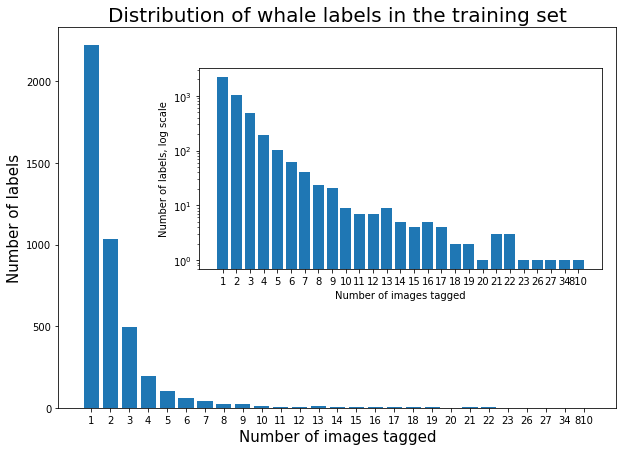

In [27]:
import matplotlib.pyplot as plt

N = len(whale_dist)
vals = list(whale_dist.values())
keys = list(whale_dist.keys())

# Plot main bar graph:
fig, ax1 = plt.subplots(figsize=(10,7))
plt.title('Distribution of whale labels in the training set', fontsize=20)
ax1.bar(range(N), vals, align='center')
ax1.set_xticks(range(N))
ax1.set_xticklabels(keys)
ax1.set_xlabel('Number of images tagged', fontsize=15)
ax1.set_ylabel('Number of labels', fontsize=15)

# Plot the inset:
left, bottom, width, height = [0.32, 0.4, 0.56, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.bar(range(N), vals, align='center')
ax2.set_xticks(range(N))
ax2.set_xticklabels(keys)
ax2.set_yscale('log')
ax2.set_xlabel('Number of images tagged', fontsize=10)
ax2.set_ylabel('Number of labels, log scale', fontsize=10)

This plot is the visual representation of the Counter object printed out above it. Inset is the same plot on a log scale to help illustrate low end of the Y-axis. This is very interesting -- it says that there are 2,220 whales that have just 1 image containing its tag; 1,034 whales have 2 images containing its tag; and so on all the way down to one tag containing 810 associated images! Which one is it? You might have guessed it by now but let's be sure:

In [ ]:
print(train_df['Id'].value_counts())

As expected, new_whale is the category with the overwhelming majority of tags. So we have a big problem...if we want to train a classifier to identify each of these whales, we'll need a lot more images for each whale! Even 34 is a low number, so we are going to want to augment our data in order to fill this out more.

Later, we'll discuss how we'll go about doing the augmentation of this dataset. For now, let's continue our exploration of the training data to see if there are other issues to consider.

## Examining the images themselves

Now that we have identified our first issue of needing to augment our image dataset, we should examine the images themselves. If they don't share specific properties like size dimensions, color scheme, etc. then we may run into additional issues. Let's load in some images and see what we find!

In [ ]:
import matplotlib.image as mpimg

# Let's plot up the first 25 images in the training data set:
image_names = np.reshape([str(i) for i in train_df.Image[0:25]], (5,5))
image_id = np.reshape([str(j) for j in train_df.Id[0:25]], (5,5))
fig, axes = plt.subplots(5,5, figsize=(16,12))
for row in range(5):
    for col in range(5):
        img = mpimg.imread('{}train/{}'.format(PATH, image_names[row, col]))
        axes[row, col].imshow(img, cmap='gray')
        axes[row,col].set_title(image_id[row,col], fontsize=15)
        axes[row, col].xaxis.set_ticklabels([])
        axes[row, col].yaxis.set_ticklabels([])

So there's a number of things we can see from these first 25 images. First, they aren't all the same size dimensions. This implies we will either have to make a classifier that doesn't care about image size, or we'll have to standardize the dimensions of each image for proper comparison. 

Second, some of the images are in grayscale, but others are in color. That means our classifier will have to not care much about whether or not the image is in color, or we'll have to standardize all images to grayscale. It's likely a better approach to just test any given image for color, and then add the grayscaled version of it to the dataset as a separate image; this will help us in our augmentation step, since it adds more data to our sample. I'm not sure however if doing this will bias the classifier to misclassify whales in our sample that do not have originally have color if presented with a color version of the same whale. __[Another analysis](https://www.kaggle.com/mmrosenb/whales-an-exploration)__ points out that some of the images are actually in redscale rather than full color (or at least emphasizing the R portion of the image for some reason). This could complicate our coloring analysis further.

Lastly, you can see the first image has a label section of sorts in the bottom portion of the image. The words in the label "HWC # 1034" doesn't seem to correlate with the whale's label. Having images with these arbitrary labels at the bottom could also further complicate things, though I am uncertain how we would go about removing them, especially since many of these labels (not shown in the figure) are very different.